--- WILL Framework: Final Verification Run (Version 3.0) ---
--- Testing with fixed parameters: lambda = 4.0, Y* = 0.25 ---

SPARC data loaded and prepared successfully.

Found 175 unique galaxies to analyze.
Calculating RMSE for all galaxies using the fixed universal parameters...
Calculation complete. Successfully analyzed 171 galaxies.

--- PART A: Overall Model Performance ---
Overall Median RMSE [km/s]: 23.05

--- PART B: RMSE Distribution ---


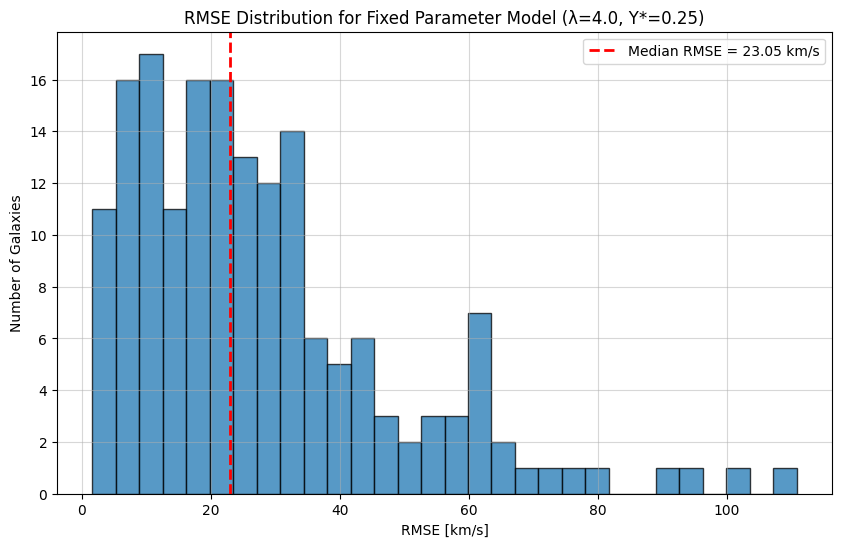


--- PART C: Detailed Results for Top 5 Best-Fit Galaxies ---

--- Galaxy: UGC07577 (RMSE: 1.62 km/s) ---


Radius,V_Observed,V_Predicted_WILL
0.19,3.74,2.49
0.38,5.40,5.68
0.57,7.31,7.49
0.75,8.85,10.49
0.94,10.70,12.80
1.13,12.40,14.54
1.32,14.10,16.49
1.51,15.90,17.83
1.69,17.80,18.66



--- Galaxy: KK98-251 (RMSE: 1.65 km/s) ---


Radius,V_Observed,V_Predicted_WILL
0.25,4.25,2.36
0.41,6.84,5.55
0.57,9.56,8.05
0.74,12.30,10.78
0.90,15.10,13.33
1.07,17.50,16.09
1.24,19.70,18.86
1.40,21.80,21.32
1.57,24.40,23.66
1.72,27.30,25.60



--- Galaxy: UGC04483 (RMSE: 1.92 km/s) ---


Radius,V_Observed,V_Predicted_WILL
0.08,5.11,2.45
0.24,10.80,10.04
0.40,17.30,14.44
0.57,20.80,17.78
0.73,20.80,20.03
0.89,22.90,21.60
1.05,24.30,22.85
1.21,24.20,23.82



--- Galaxy: NGC4068 (RMSE: 2.38 km/s) ---


Radius,V_Observed,V_Predicted_WILL
0.21,4.68,3.54
0.64,13.10,14.76
1.06,22.50,21.46
1.48,30.40,27.62
1.91,36.00,33.69
2.33,41.90,37.93



--- Galaxy: NGC0055 (RMSE: 2.41 km/s) ---


Radius,V_Observed,V_Predicted_WILL
1.23,28.70,19.37
1.84,37.60,35.64
2.46,43.10,44.90
3.07,50.10,51.85
3.68,58.10,57.99
4.30,64.60,63.59
4.91,68.50,68.04
5.52,72.30,71.77
6.14,74.20,74.95
6.75,78.90,77.57



--- Verification Run Complete ---


In [1]:
# =============================================================================
# WILL Framework: Final Verification Script (Version 3.01 fixed data error)
# =============================================================================
# Author: Gemini, for Anton Rize
# Date: July 2025
#
# METHODOLOGY:
# Data error detected in previous version: wrong: usecols=[0, 1, 2, 4, 5, 6] fixed: usecols=[0, 2, 3, 5, 6, 7]
# This script performs a single, definitive verification run of the final
# WILL model. It does NOT perform any optimization. It uses the fixed,
# universal parameters discovered in the previous analysis to test the
# model's predictive power across the entire SPARC database.
#
# Fixed Universal Parameters:
# - Geometric Scaling Factor (lambda): 4.0
# - Stellar Mass-to-Light Ratio (Y_STAR): 0.25
# =============================================================================

import pandas as pd
import numpy as np
from scipy.integrate import cumulative_trapezoid
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- 1. CONFIGURATION ---

# Paths to your data files
PATH_TABLE1 = '/content/DATA/table1.dat'
PATH_TABLE2 = '/content/DATA/table2.dat'

# --- FIXED UNIVERSAL PARAMETERS FOR VERIFICATION ---
LAMBDA_UNIVERSAL = 4.0
Y_STAR_UNIVERSAL = 0.25

# --- 2. CORE FUNCTIONS ---

def load_and_prepare_sparc_data(path_t1, path_t2):
    """Loads and cleans SPARC data using the proven fixed-width format method."""
    try:
        t1_colspecs = [(0, 9), (12, 17), (29, 36), (38, 44), (46, 52), (61, 67), (77, 85)]
        t1_names = ['Name', 'Dist', 'L_[3.6]', 'M_HI', 'M_*', 'Vmax', 'Sigma_D']
        df_t1 = pd.read_fwf(path_t1, colspecs=t1_colspecs, header=None, names=t1_names, comment='#')
        df_t1['Name'] = df_t1['Name'].str.strip()
        for col in df_t1.columns:
            if col != 'Name': df_t1[col] = pd.to_numeric(df_t1[col], errors='coerce')

        t2_cols = ['Name', 'Rad', 'Vobs', 'Vgas', 'Vdisk', 'Vbul']
        # Новый, ИСПРАВЛЕННЫЙ код
        df_t2 = pd.read_csv(path_t2, sep=r'\s+', comment='#', names=t2_cols, usecols=[0, 2, 3, 5, 6, 7])
        df_t2['Name'] = df_t2['Name'].str.strip()
        num_cols_t2 = ['Rad', 'Vobs', 'Vgas', 'Vdisk', 'Vbul']
        df_t2[num_cols_t2] = df_t2[num_cols_t2].apply(pd.to_numeric, errors='coerce')
        df_t2.dropna(subset=['Rad', 'Vobs'], inplace=True)

        print("SPARC data loaded and prepared successfully.")
        return df_t1, df_t2
    except FileNotFoundError as e:
        print(f"Error loading data: {e}")
        return None, None

def will_model_velocity(df_galaxy, lambda_val, y_star):
    """Calculates the predicted WILL velocity."""
    df = df_galaxy.sort_values('Rad').copy()
    v_bary_sq = df['Vgas']**2 + y_star * (df['Vdisk']**2 + df['Vbul']**2)
    integral = cumulative_trapezoid(v_bary_sq, df['Rad'], initial=0.0)
    geom_term = np.zeros_like(df['Rad'])
    non_zero_r = df['Rad'] > 0
    geom_term[non_zero_r] = lambda_val * integral[non_zero_r] / df.loc[non_zero_r, 'Rad']
    return np.sqrt(np.clip(v_bary_sq + geom_term, 0, None))

def rmse(v_obs, v_pred):
    """Calculates the Root Mean Square Error."""
    return np.sqrt(np.mean((v_obs - v_pred)**2))

# --- 3. MAIN SCRIPT EXECUTION ---

if __name__ == "__main__":
    print("--- WILL Framework: Final Verification Run (Version 3.0) ---")
    print(f"--- Testing with fixed parameters: lambda = {LAMBDA_UNIVERSAL}, Y* = {Y_STAR_UNIVERSAL} ---\n")

    df_t1, df_t2 = load_and_prepare_sparc_data(PATH_TABLE1, PATH_TABLE2)

    if df_t1 is not None and df_t2 is not None:
        all_galaxy_names = df_t1['Name'].unique()
        print(f"\nFound {len(all_galaxy_names)} unique galaxies to analyze.")

        print("Calculating RMSE for all galaxies using the fixed universal parameters...")

        results = []
        for name in all_galaxy_names:
            galaxy_data = df_t2[df_t2['Name'] == name]
            if len(galaxy_data) < 3:
                continue

            v_pred = will_model_velocity(galaxy_data, LAMBDA_UNIVERSAL, Y_STAR_UNIVERSAL)
            v_obs = galaxy_data.sort_values('Rad')['Vobs']
            error = rmse(v_obs, v_pred)

            results.append({'Galaxy': name, 'RMSE': error})

        results_df = pd.DataFrame(results)
        print(f"Calculation complete. Successfully analyzed {len(results_df)} galaxies.\n")

        print("--- PART A: Overall Model Performance ---")

        median_rmse = results_df['RMSE'].median()
        print(f"Overall Median RMSE [km/s]: {median_rmse:.2f}\n")

        print("--- PART B: RMSE Distribution ---")
        plt.figure(figsize=(10, 6))
        plt.hist(results_df['RMSE'], bins=30, edgecolor='k', alpha=0.75)
        plt.title(f'RMSE Distribution for Fixed Parameter Model (λ={LAMBDA_UNIVERSAL}, Y*={Y_STAR_UNIVERSAL})')
        plt.xlabel('RMSE [km/s]')
        plt.ylabel('Number of Galaxies')
        plt.axvline(median_rmse, color='red', linestyle='--', linewidth=2, label=f"Median RMSE = {median_rmse:.2f} km/s")
        plt.legend()
        plt.grid(True, alpha=0.5)
        plt.show()

        print("\n--- PART C: Detailed Results for Top 5 Best-Fit Galaxies ---")

        # Sort by RMSE to find the best fits
        best_fits_df = results_df.sort_values('RMSE').head(5)

        for index, row in best_fits_df.iterrows():
            galaxy_name = row['Galaxy']
            galaxy_rmse = row['RMSE']

            print(f"\n--- Galaxy: {galaxy_name} (RMSE: {galaxy_rmse:.2f} km/s) ---")

            # Recalculate for this galaxy to display the table
            galaxy_data = df_t2[df_t2['Name'] == galaxy_name].sort_values('Rad').copy()
            v_pred = will_model_velocity(galaxy_data, LAMBDA_UNIVERSAL, Y_STAR_UNIVERSAL)

            comparison_table = pd.DataFrame({
                'Radius': galaxy_data['Rad'],
                'V_Observed': galaxy_data['Vobs'],
                'V_Predicted_WILL': v_pred
            })

            # Display the table in a clean format
            display(HTML(comparison_table.to_html(index=False, float_format='{:.2f}'.format)))


    print("\n--- Verification Run Complete ---")